In [1]:
###############################################################################
# OPTIMIZATION & AI - LAB 06 - FERHAT Matthieu & LOVITON Pierre
###############################################################################

In [2]:
# System imports
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random

#Extra library imports
import pandas as pd
from PIL import Image
import itertools

In [9]:
#User inputs
datadir='data'
csvpath = 'sea.csv'

With the increase in the amount of available data, finding a relevant criterion to select some of them, reducing redundancy or maintaining a high standard of quality, is challenging but also crucial. For example, how can you create a photo album choosing among hundred of images taken from your camera? In this lab, we will illustrate this principle on a limited amount of data.

## I. Optimized selection of best quality images

## a) Data exploration

During your holidays, you took beautiful pictures of fishes! Let's have a look at your artistic skills.

<font color='blue'> Question 1: load the csv file using Pandas, and get automatically the number of pictures. Display also the first five rows.</font>

In [10]:
# Load the csv file
df = pd.read_csv(csvpath)

# get automatically the number of images
nb_ims = len(np.unique(df.Image_name))

# Display the first first rows
df.head()

,Image_name,Score,Time
0,im-01,0.693827,10:17:00
1,im-02,0.844092,10:17:01
2,im-03,0.845637,10:17:02
3,im-04,0.818164,10:18:00
4,im-05,0.728297,10:18:01


There are three types of features: the image name, the score and the time the associated photo was taken (hour:minute:second).
The score measures the quality of the image, more precisely the strength of blur. This score is between 0 (no blur) and 1 (totally blured image). We can visualize the evolution of the score over the images.

<font color='blue'> Question 2: create the vector of blur scores, and plot the evolution of the blur scores over the images.</font>

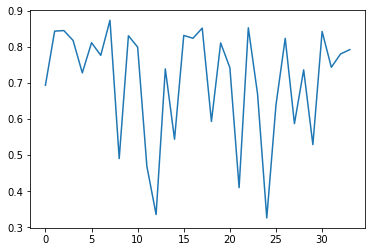

In [11]:
# Generate the vector of blur scores
q_vec = np.array(df.Score)

# Plot the quality array
plt.plot(q_vec)

We see that the quality of the taken images varies a lot! We can also have a look at some examples, to compare the images and their blur score.

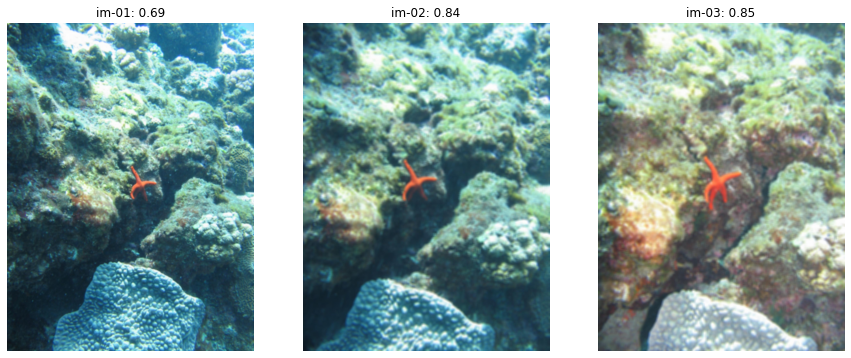

In [228]:
# Display some images and their associated blur score
impaths = np.sort(glob.glob(os.path.join(datadir, '*.jpg')))
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for cnt, impath in enumerate(impaths[:3]):
    # Load the selected image
    im_arr = np.array(Image.open(impath))
    imname = os.path.basename(impath).split('.')[0]
    score = list(df[df['Image_name']==imname].Score)[0]

    # Display the selected image 
    ax[cnt].imshow(im_arr)
    ax[cnt].axis('off')
    ax[cnt].set_title('{}: {:.2f}'.format(imname, score))
plt.show()
###############################################################################

Thus, if we select only one image between these three ones, the first one is the best choice according to the blur score.
To create our photo album, we want to select k images of best possible quality. However, we want also these k images to picture very different scenes to resume well the whole diving session. For example, if we select these three images, we totally miss the pictures containing fishes, and so the main part of our diving session...

Thus we add another criterion: we also want the k selected images to have been taken as far as possible from each other.
We will now implement the associated loss.

## b) Formulation of a loss function

First, we need to convert the time vector into a more appropriate vector. For example, we create a new vector representing the difference in seconds between each image and the first one.

<font color='blue'> Question 3: create the vector of time difference in seconds from each picture to the first one. You may use the *split* function. Display the time difference in seconds between the last picture and the first one.</font>

In [71]:
# Get the vector of picture times (hour:minute:seconds)
times = np.array(df.Time)

# Convert it into the vector of time difference in seconds 
# from each picture to the first one
sec_vec = []
for i in range (len(df.Time.values)):
    h = int(df.Time[i].split(':')[0])
    m = int(df.Time[i].split(':')[1])
    s = int(df.Time[i].split(':')[2])
    sec_vec.append(60*60*h+60*m+s)

dt_vec = []    
for i in range (len(df.Time.values)):
    if i==0:
        dt_vec.append(0)
        i=i+1
    else:
        dt_vec.append(sec_vec[i]-sec_vec[0])
        i=i+1
print(dt_vec)
dt_vec = np.array(dt_vec)
# Get the difference in seconds between the first and last pictures 
d_max = max(dt_vec)-min(dt_vec)
print(d_max)

[0, 1, 2, 60, 61, 120, 121, 180, 181, 840, 841, 842, 1020, 1021, 1080, 1081, 1082, 1083, 1140, 1141, 1200, 1201, 1202, 1260, 1261, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1440, 1441]
1441


Hopefully, you can also check that the time difference in seconds from the first picture to itself is 0!
We will now create a loss function that is a trade-off between the maximization of the quality of the k selected images and the maximization of the time between two consecutives selected images. This loss to minimize can for example be computed as:

$\displaystyle \frac{0.5}{k-1} \sum_{j=1}^{k-1} \left(1 - \frac{\Delta t(i_{j+1}) - \Delta t(i_j)}{d_{max}} \right)+  \frac{0.5}{k}\sum_{j=1}^k q(i_j)$

with $i = [i_1, ..., i_k]$ the vector of indexes of the $k$ selected images, $\Delta t$ the vector of time difference in seconds from each picture to the first one,  $d_{max}$ the maximum time difference in seconds, and $q$ the vector of blur scores. The factor of 0.5 allows obtaining a loss value in [0, 1], and a balanced trade-off between image quality and time difference.

<font color='blue'> Question 4: complete the loss function below.</font>

In [80]:
def my_loss(q_vec, dt_vec, idxs, d_max):
    """ The loss to minimize
        
    Parameters
    ----------
    q_vec: 1D array
        vector of image quality
    dt_vec: 1D array
        vector of time difference in seconds between each image and the first 
        one
    idxs: list/tuple of positive integers
        vector containing indexes of the images to select
    d_max: float/int
        maximum time difference in seconds
        
    Returns
    -------
    loss: float
        output loss value
        
    Command:
    -------
    loss = my_loss(q_vec, dt_vec, idxs, d_max)
    """    
    # Sort the images indexes (for safety)
    idxs = np.sort(idxs)
    
    # Compute the loss
    d_loss = dt_vec[idxs[1:]]-dt_vec[idxs[:len(idxs)-1]]
    d_loss = np.mean(1-(d_loss/d_max))
    q_loss = np.mean(q_vec[idxs])
    loss = 0.5*(d_loss+q_loss)
    
    return loss

Thus, if we select only the first three images, we should obtain an unsatisfying loss value.

In [81]:
# Loss value if selecting only the first three images
loss = my_loss(q_vec, dt_vec, [0, 1, 2], d_max)
print(loss)

0.8969124171515748


We will now improve the result performing a global optimization method we just saw during the course: the simulated annealing.

## c) Automatic selection of 3 images using simulated annealing

To use simulated annealing, we need to randomly select a neighbouring solution at each iteration. We choose to randomly select a selected element (with value 1) of the vector of the current solution $x$, and to permute its value with an unselected element (with value 0) of $x$. For example, in a problem consisting in selecting 2 images among 5, 10010 and 00110 are neighbouring solutions obtained after permutation of the first and third elements. Moreover, the number of images to select does not change using this approach!
To simplify, we set the parameter $k$ associated with the Boltzmann constant to 1.


We can now optimize the photo selection using simulated annealing and this notion of neighbourhood.

<font color='blue'> Question 5: complete the optimization function below.</font>

In [23]:
a = random.sample(range(0,34),3)
print(a)
x2 = list(np.copy(x0))
x2[x2.index(a[0])]=a[1]
x2[x2.index(a[1])]=a[0]

[19, 23, 7]


ValueError: 19 is not in list

In [20]:
k=3
m=34
im_ids = np.array(list(range(len(q_vec))))

x0 = np.append(np.ones(k,dtype=int),np.zeros(m-k,dtype=int))
x2 = np.random.permutation(x0)

        # Vector of selected indexes for both solutions
        #idxs = list(map(lambda a: a if a==x[0] or a==x[1] or a==x[2] else 0,im_ids))
idxs = im_ids[x0==1]
idxs2 = im_ids[x2==1]

print('\n',idxs)
print(idxs2)


 [0 1 2]
[ 5 10 20]


In [15]:
def select_photos(q_vec, dt_vec, x0, d_max, T0, tau, nb_its):
    """ Optimization using simulated annealing
        
    Parameters
    ----------
    q_vec: 1D array
        vector of image quality
    dt_vec: 1D array
        vector of time difference in seconds between each image and the first 
        one
    x0: list/tuple of positive integers
        vector containing the initial indexes of the images to select
    d_max: float/int
        maximum time difference in seconds
    T0: float
        temperature parameter
    tau: float
        temperature decrease hyperparameter
    nb_its: strictly positive integer
        number of iterations
        
    Returns
    -------
    x: array of positive integers
        vector of selected indexes after optimization
    losses: list of floats
        vector of loss values over the iterations
        
    Command:
     x, losses = select_photos(q_vec, dt_vec, x0, d_max, T0, tau, nb_its)
    """  
    
    # Initialize the loss vector
    losses = []
    
    # Initialize the temperature
    T = np.copy(T0)
    
    # Initialize the vector of selected photos
    x = np.copy(x0)
    
    # Vector of photos identifiers
    im_ids = np.array(list(range(len(q_vec))))

    # Iterative process
    for it in range(nb_its):
            
        # Create a candidate solution using random permutation
        #x2 = np.random.permutation(len(im_ids))[0:3]
        x2 = np.random.permutation(x)


        # Vector of selected indexes for both solutions
        #idxs = list(map(lambda a: a if a==x[0] or a==x[1] or a==x[2] else 0,im_ids))
        idxs = im_ids[x==1]
        idxs2 = im_ids[x2==1]
        #idxs2 = list(map(lambda a: a if a==x2[0] or a==x2[1] or a==x2[2] else 0,im_ids))
        
        # Compute the loss of the current solution
        loss1 = my_loss(q_vec, dt_vec, idxs, d_max) 
        
        # Compute the loss of the candidate solution
        loss2 = my_loss(q_vec, dt_vec, idxs2, d_max)

        # Compute the difference between the two solutions
        delta = loss2-loss1
        
        # Perform the simulated annealing step
        if delta <= 0:
            x = x2
            new_loss = loss2
        else:
            if random.random() <= np.exp((-delta)/T):
                x = x2
                new_loss = loss2
            else:
                new_loss = loss1
                                
        # Update the temperature hyperparameter        
        T = T * tau
    
        # Update the loss vector
        losses.append(new_loss)
        
    return x, losses   

We can now improve our first result applying simulated annealing.

<font color='blue'> Question 6: perform simulated annealing to automatically select k=3 images. Use the following hyperparameter values: T=0.1, $\tau = 0.9$ and 500 iterations. Initialize the algorithm selecting the three first images. Display the optimized loss value, the selected images, their names and their blur scores.</font>

The optimized loss value is 0.504728139829264


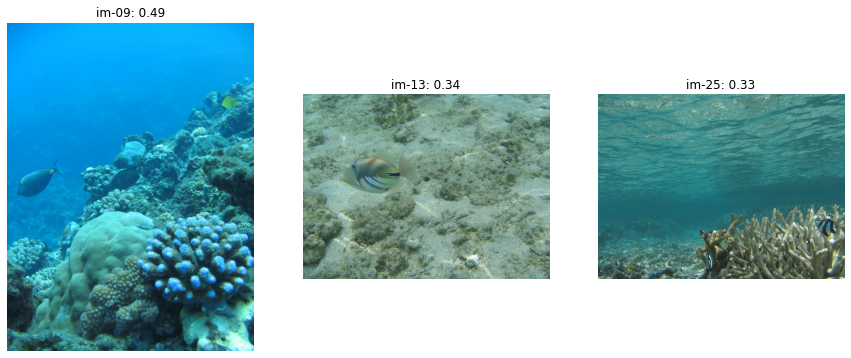

In [358]:
# Hyperparameter setting
T0 = 0.1
tau = 0.9
nb_its = 500
k = 3
m = 34
# Initialize the vector of solutions
x0 = np.append(np.ones(k,dtype=int),np.zeros(m-k,dtype=int))

# Optimization using Simulated Annealing
x,losses = select_photos(q_vec, dt_vec, x0, d_max, T0, tau, nb_its)
# Display the optimized loss value
print("The optimized loss value is",losses[-1])


# Display the selected images, their names and scores
impaths = np.sort(glob.glob(os.path.join(datadir, '*.jpg')))
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for cnt, impath in enumerate(impaths[list(np.array(list(range(len(q_vec))))[x==1])]):
    # Load the selected image
    im_arr = np.array(Image.open(impath))
    imname = os.path.basename(impath).split('.')[0]
    score = list(df[df['Image_name']==imname].Score)[0]

    # Display the selected image 
    ax[cnt].imshow(im_arr)
    ax[cnt].axis('off')
    ax[cnt].set_title('{}: {:.2f}'.format(imname, score))
plt.show()
###############################################################################

<font color='blue'> Question 7: plot the evolution of the loss over the iterations. Is the algorithm converging? Can you conclude on the needed number of iterations to converge? Why?</font>

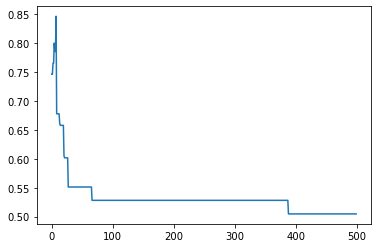

In [359]:
plt.plot(losses)

<font color='blue'> We can see on the plot that the algorithm converge well but we needed only around 100 iterations to already have a great result.</font>

Because we selected few images, we can check our result using using brute-force.

<font color='blue'> Question 8: how many different possible solutions exist? Write this number as a function of $k$, the number of images to select, and $n$, the total number of images. Display the names of the selected images using brute force with the *combinations* function of itertools. Did we retrieve the same result using simulated annealing? </font>

In [237]:
def func(k,n):
    a = itertools.combinations(range(n),k)
    y = [i for i in a]
    lst=[]
    for i in range(len(y)):
        loss = my_loss(q_vec, dt_vec, y[i], d_max)
        lst.append(loss)
    mini = min(lst)
    indx_mini = np.where(lst==mini)
    combi = y[int(indx_mini[0])]
    return mini, combi

In [238]:
mini, combi = func(3,34)

In [239]:
print("The minimal loss value found using brute-force method is",mini)

The minimal loss value found using brute-force method is 0.504728139829264


In [244]:
print("The corresponding combination of images is",combi)

The corresponding combination of images is (8, 12, 24)


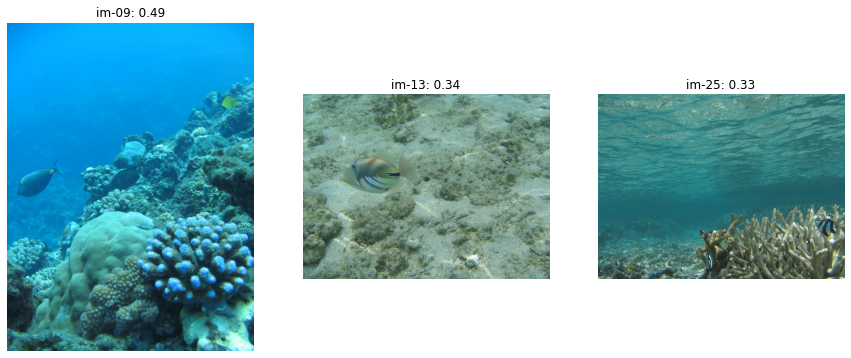

In [249]:
# Display the selected images, their names and scores
impaths = np.sort(glob.glob(os.path.join(datadir, '*.jpg')))
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for cnt, impath in enumerate(impaths[list(combi)]):
    # Load the selected image
    im_arr = np.array(Image.open(impath))
    imname = os.path.basename(impath).split('.')[0]
    score = list(df[df['Image_name']==imname].Score)[0]

    # Display the selected image 
    ax[cnt].imshow(im_arr)
    ax[cnt].axis('off')
    ax[cnt].set_title('{}: {:.2f}'.format(imname, score))
plt.show()
###############################################################################

<font color='blue'> We retrieve the same result between the brute force method and the simulated annealing one. But if we run again the simulated annealing method, we may have a different result (not better), because of his random part. Here the running time isn't very large for the brute force (35^3) but imagine with 1 000 000 ^100,... This method wouldn't be too efficient, and simulated annealing method will show all his strength. </font>

We can also increase the number of selected photos to complete our photo album.

## d) Automatic selection of k images using simulated annealing

<font color='blue'> Question 9: select automatically 6 images using simulated annealing. Keep the same hyperparameters values as previously. Display the optimized loss value, the selected images, their names and blur scores. </font>

The optimized loss value is 0.671638669557574


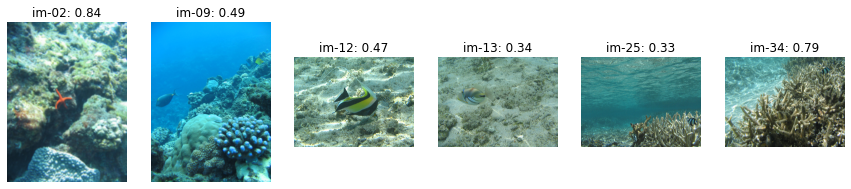

In [360]:
# Hyperparameter setting
T0 = 0.1
tau = 0.9
nb_its = 500
k = 6
m = 34
# Initialize the vector of solutions
x0 = np.append(np.ones(k,dtype=int),np.zeros(m-k,dtype=int))

# Optimization using Simulated Annealing
x,losses = select_photos(q_vec, dt_vec, x0, d_max, T0, tau, nb_its)
# Display the optimized loss value
print("The optimized loss value is",losses[-1])


# Display the selected images, their names and scores
impaths = np.sort(glob.glob(os.path.join(datadir, '*.jpg')))
fig, ax = plt.subplots(1, 6, figsize=(15, 15))
for cnt, impath in enumerate(impaths[list(np.array(list(range(len(q_vec))))[x==1])]):
    # Load the selected image
    im_arr = np.array(Image.open(impath))
    imname = os.path.basename(impath).split('.')[0]
    score = list(df[df['Image_name']==imname].Score)[0]

    # Display the selected image 
    ax[cnt].imshow(im_arr)
    ax[cnt].axis('off')
    ax[cnt].set_title('{}: {:.2f}'.format(imname, score))
plt.show()
###############################################################################

<font color='blue'> Question 10: plot the evolution of the optimized loss values increasing the number of selected images $k$ from 2 to 33. Comment.</font>

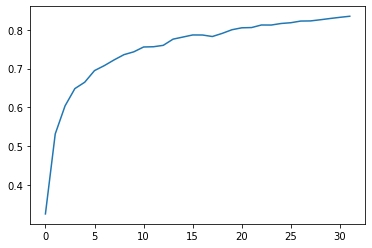

In [362]:
opt_loss = []

# Hyperparameter setting
T0 = 0.1
tau = 0.9
nb_its = 500
m = 34

for k in range (2,34):
    # Initialize the vector of solutions
    x0 = np.append(np.ones(k,dtype=int),np.zeros(m-k,dtype=int))

    # Optimization using Simulated Annealing
    x,losses = select_photos(q_vec, dt_vec, x0, d_max, T0, tau, nb_its)
    
    opt_loss.append(losses[-1])
    
plt.plot(opt_loss)

<font color='blue'> We can see that the optimized loss value increase when k increases. The evolution is following the logarithmic one. To complete this album with a number of images k optimized, we should choose between 3 and 5 images.</font>